In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

C:\Users\dgdl1\AppData\Local\Temp\ipykernel_18456\3663180021.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pm25_m   = pm25.loc[idx].resample('M').mean()
C:\Users\dgdl1\AppData\Local\Temp\ipykernel_18456\3663180021.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pm10_m   = pm10.loc[idx].resample('M').mean()
C:\Users\dgdl1\AppData\Local\Temp\ipykernel_18456\3663180021.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  asthma_m = asthma.loc[idx].resample('M').sum()
C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Test MSE: 164185261.5, RMSE: 12813.5, R2: -6.001


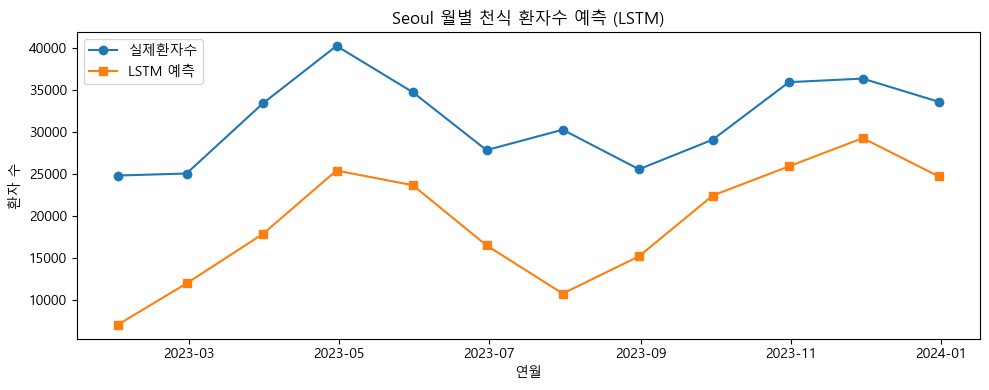

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1) 데이터 불러오기 & 월별 집계
asthma = pd.read_excel('Asthma_top30_Sum_removed_outliers.xlsx',
                       index_col=0, parse_dates=True)
pm25   = pd.read_excel('pm25_top30_fixed.xlsx',
                       index_col=0, parse_dates=True)
pm10   = pd.read_excel('pm10_top30_fixed.xlsx',
                       index_col=0, parse_dates=True)

idx      = pm25.index.intersection(asthma.index).intersection(pm10.index)
pm25_m   = pm25.loc[idx].resample('M').mean()
pm10_m   = pm10.loc[idx].resample('M').mean()
asthma_m = asthma.loc[idx].resample('M').sum()

# 예시로 서울 한 도시만 사용
city = 'Seoul'
df = pd.DataFrame({
    'pm25':   pm25_m[city],
    'pm10':   pm10_m[city],
    'asthma': asthma_m[city]
}).dropna()

# 2) MinMax 스케일링
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# 3) 시퀀스 생성 함수 (과거 n_steps 로 다음 asthma 예측)
def make_sequences(data, n_steps=12):
    X, y = [], []
    for i in range(len(data)-n_steps):
        seq_x = data[i:i+n_steps, :2]     # pm25, pm10
        seq_y = data[i+n_steps, 2]        # asthma
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 12
X, y = make_sequences(scaled, n_steps=n_steps)

# 4) train/test 분리 (마지막 12개월을 테스트)
train_size = len(X) - 12
X_train, y_train = X[:train_size], y[:train_size]
X_test,  y_test  = X[train_size:], y[train_size:]

# 5) LSTM 모델 정의
model = Sequential([
    LSTM(64, input_shape=(n_steps, 2), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 6) 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=100, batch_size=8,
    validation_split=0.1, verbose=0
)

# 7) 예측 및 역스케일링
y_pred = model.predict(X_test).ravel()
# asthma 스케일만 역변환
asthma_min = scaler.data_min_[2]
asthma_max = scaler.data_max_[2]
y_test_orig = y_test * (asthma_max-asthma_min) + asthma_min
y_pred_orig = y_pred * (asthma_max-asthma_min) + asthma_min

# 8) 성능 평가
mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)
r2  = r2_score(y_test_orig, y_pred_orig)
print(f"Test MSE: {mse:.1f}, RMSE: {rmse:.1f}, R2: {r2:.3f}")

# 9) 예측 vs 실제 시각화
dates = df.index[n_steps+train_size : n_steps+train_size+len(y_test)]
plt.figure(figsize=(10,4))
plt.plot(dates, y_test_orig, label='실제환자수', marker='o')
plt.plot(dates, y_pred_orig, label='LSTM 예측',   marker='s')
plt.title(f'{city} 월별 천식 환자수 예측 (LSTM)')
plt.xlabel('연월')
plt.ylabel('환자 수')
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
# 이번엔 전체 도시 예측

C:\Users\dgdl1\AppData\Local\Temp\ipykernel_18456\2614828700.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pm25_m   = pm25.loc[idx].resample('M').mean()
C:\Users\dgdl1\AppData\Local\Temp\ipykernel_18456\2614828700.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pm10_m   = pm10.loc[idx].resample('M').mean()
C:\Users\dgdl1\AppData\Local\Temp\ipykernel_18456\2614828700.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  asthma_m = asthma.loc[idx].resample('M').sum()


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


C:\Users\dgdl1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
                      MSE      RMSE     R2
city                                      
Ansan        6.622789e+05   813.805 -1.938
Anyang       4.057427e+05   636.979 -3.397
Bucheon      7.310046e+05   854.988 -1.829
Busan        1.828878e+07  4276.539 -6.168
Cheongju     1.690090e+06  1300.035 -2.608
Daegu        6.161582e+06  2482.253 -1.592
Daejeon      1.437274e+06  1198.864 -0.833
Dongducheon  1.953493e+03    44.198 -2.094
Goyang       1.132064e+06  1063.985 -1.801
Gunpo        6.441112e+04   253.793 -1.978
Guri         8.164813e+04   285.741 -4.571
Gwacheon     4.801233e+03    69.291 -2.166
Gwangju      6.513458e+06  2552.148 -6.085
Gwangmyeong  1.529846e+04   123.687 -0.804
Hwaseong     1.293573e+06  1137.353 -2.855
Icheon       4.091006e+04   202.262 -3.044
Iksan        1.956268e+05   442.297 -3.419
Incheon      1.200999e+07  3465.544 -2.769
Jeongeup     3.227619e+04   179.656 -6.088
Osan         3.233101e+04   179.808 -0.076
Paju         9.

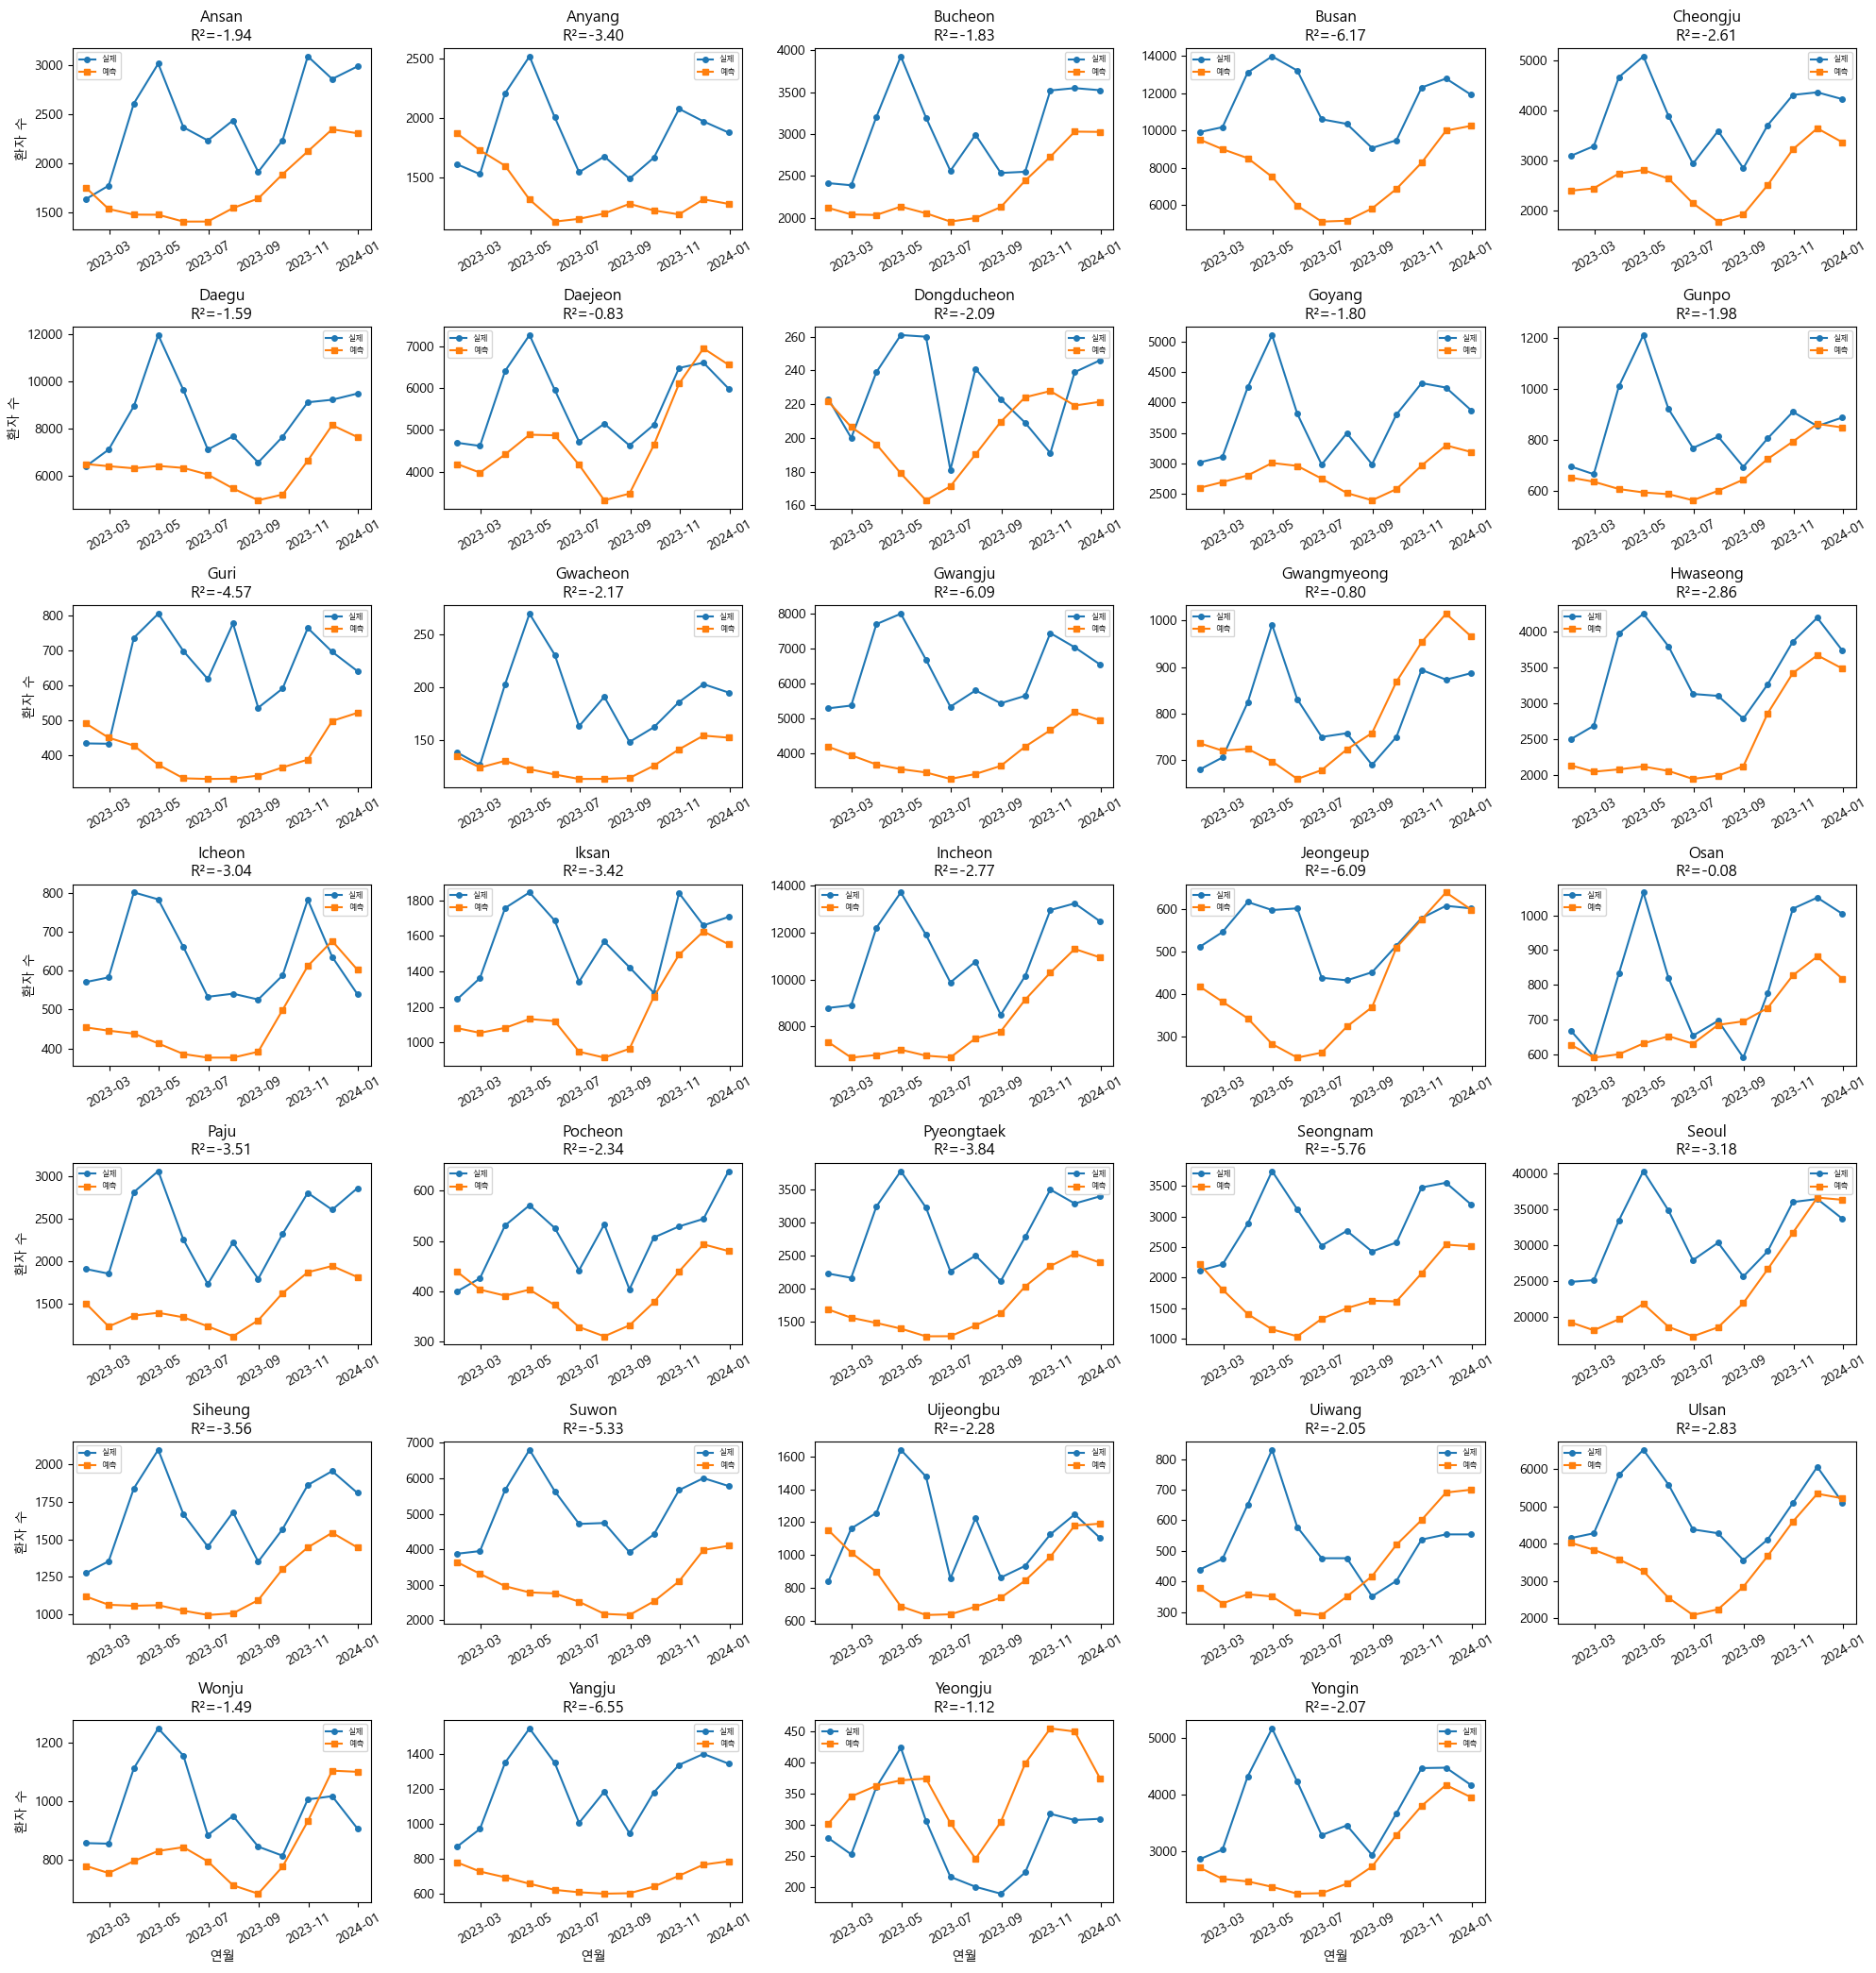

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import backend as K

# 1) 데이터 불러오기 & 월별 집계
asthma = pd.read_excel('Asthma_top30_Sum_removed_outliers.xlsx',
                       index_col=0, parse_dates=True)
pm25   = pd.read_excel('pm25_top30_fixed.xlsx',
                       index_col=0, parse_dates=True)
pm10   = pd.read_excel('pm10_top30_fixed.xlsx',
                       index_col=0, parse_dates=True)

# 공통 인덱스 및 월별 집계
idx      = pm25.index.intersection(asthma.index).intersection(pm10.index)
pm25_m   = pm25.loc[idx].resample('M').mean()
pm10_m   = pm10.loc[idx].resample('M').mean()
asthma_m = asthma.loc[idx].resample('M').sum()

# 2) 시퀀스 생성 함수
def make_sequences(data, n_steps=12):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps, :2])  # pm25, pm10
        y.append(data[i+n_steps, 2])     # asthma
    return np.array(X), np.array(y)

# 3) 준비: 도시 리스트, 결과 저장용
cities = sorted(list(set(pm25.columns) &
                     set(pm10.columns) &
                     set(asthma.columns)))
results = []
preds, trues, dates = {}, {}, {}

n_steps = 12

for city in cities:
    # a) 도시별 DataFrame 준비 및 결측 제거
    df = pd.DataFrame({
        'pm25':   pm25_m[city],
        'pm10':   pm10_m[city],
        'asthma': asthma_m[city]
    }).dropna()

    if len(df) < n_steps + 12:
        print(f"스킵: {city} (데이터 부족)")
        continue

    # b) 스케일링
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    # c) 시퀀스 생성
    X, y = make_sequences(scaled, n_steps=n_steps)

    # d) train/test 분리 (마지막 12개월 테스트)
    split = len(X) - 12
    X_train, y_train = X[:split], y[:split]
    X_test,  y_test  = X[split:], y[split:]

    # e) 모델 초기화 전 세션 클리어
    K.clear_session()
    model = Sequential([
        LSTM(64, input_shape=(n_steps, 2)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # f) 학습
    model.fit(X_train, y_train,
              epochs=50, batch_size=8,
              verbose=0)

    # g) 예측 및 역스케일
    y_pred = model.predict(X_test).ravel()
    # asthma 변수만 역변환
    amin, amax = scaler.data_min_[2], scaler.data_max_[2]
    y_test_orig = y_test * (amax-amin) + amin
    y_pred_orig = y_pred * (amax-amin) + amin

    # h) 성능 저장
    mse  = mean_squared_error(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_test_orig, y_pred_orig)
    results.append([city, mse, rmse, r2])

    # i) 예측·실제·날짜 저장
    test_dates = df.index[n_steps+split : n_steps+split+len(y_test)]
    preds[city] = y_pred_orig
    trues[city] = y_test_orig
    dates[city] = test_dates

# 4) 성능 테이블 출력
metrics_df = pd.DataFrame(results, columns=['city','MSE','RMSE','R2'])\
               .set_index('city')
print(metrics_df.round(3))

# 5) 도시별 예측 vs 실제 시각화
n = len(metrics_df)
cols = 5
rows = int(np.ceil(n/cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), sharex=False)
axes = axes.flatten()

for i, city in enumerate(metrics_df.index):
    ax = axes[i]
    ax.plot(dates[city], trues[city], label='실제', marker='o', ms=4)
    ax.plot(dates[city], preds[city], label='예측', marker='s', ms=4)
    ax.set_title(f"{city}\nR²={metrics_df.loc[city,'R2']:.2f}")
    ax.tick_params(axis='x', rotation=30)
    if i%cols == 0: ax.set_ylabel('환자 수')
    if i >= (rows-1)*cols: ax.set_xlabel('연월')
    ax.legend(fontsize=6)

# 남는 축 숨기기
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
